In [1]:
import numpy as np
import h5py
np.set_printoptions(precision=3)
import pylops
import pyproximal
import matplotlib.pyplot as plt
from pyproximal.ProxOperator import _check_tau
from scipy.special import jv # J_v Besselfunction
from scipy.linalg import toeplitz
import scipy.io

In [2]:
# Define the proximal operator classes

class proxF(pyproximal.ProxOperator):
    
    def __init__(self):
        super().__init__()
       
    def __call__(self,A):
        n = int(len(A.reshape(-1))**(1/2)) 
        A.shape = (n,n)
        s, u = np.linalg.eigh(A)
        for i in s:
            if i < 0:
                return np.inf
        return 0
    
    
    def prox(self, A, tau = 1.):
        orig_shape = A.shape
        n = int(len(A.reshape(-1))**(1/2))
        A.shape = (n,n)
        
        s,u = np.linalg.eigh(A)
        s_new = np.zeros(s.shape)
        for i,si in enumerate(s):
            if si < 0:
                s_new[i] = 0
            else:
                s_new[i] = s[i]
        return (u@np.diag(s_new)@u.T).reshape(orig_shape)
class proxG(pyproximal.ProxOperator):

    def __init__(self,alpha):
        super().__init__()
        self.alpha = alpha
        self.F = proxF() 
        self.L2 = pyproximal.proximal.L2(sigma = self.alpha)
        
    def __call__(self,A):
        return self.F(A) + self.L2(A)  
    
    def prox(self, A, tau = 1.):
        return self.F.prox(self.L2.prox(A, tau),tau)


In [3]:
class L21(pyproximal.ProxOperator):
    r"""
    -----
    Given the :math:`L_{2,1}` norm of a matrix of size
    :math:`N_{dim} \times N'_x` defined as:
    .. math::
        \sigma \|\mathbf{X}\|_{2,1} = \sigma \sum_{j=0}^{N'_x} \|\mathbf{x}_j\|_2 =
        \sigma \sum_{j=0}^{N'_x} \sqrt{\sum_{i=0}^{N_{dim}}} |x_{ij}|^2
    the proximal operator is:
    .. math::
        \prox_{\tau \sigma \|\cdot\|_{2,1}}(\mathbf{x}_j) =
        \left(1 - \frac{\sigma \tau}{max\{||\mathbf{x}_j||_2,
        \sigma \tau \}}\right) \mathbf{x}_j \quad \forall j
    Similar to the Euclidean norm, the dual operator is defined as:
    .. math::
        \prox^*_{\tau \sigma \||\cdot\|_{2,1}}(\mathbf{x}_j) =
        \frac{\sigma \mathbf{x}_j}{\max\{||\mathbf{x}_j||_2, \sigma\}}
    """
    def __init__(self, ndim, sigma=1.):
        super().__init__(None, False)
        self.ndim = ndim
        self.sigma = sigma

    def __call__(self, x):
        x = x.reshape(self.ndim, len(x) // self.ndim)
        f = self.sigma * np.sum(np.sqrt(np.sum(x ** 2, axis=0)))
        return f

    @_check_tau
    def prox(self, x, tau):
        x = x.reshape(self.ndim, len(x) // self.ndim)
        aux = np.sqrt(np.sum(x ** 2, axis=0))
        aux = np.vstack([aux] * self.ndim).ravel()
        x = (1 - (tau * self.sigma) / np.maximum(aux, tau * self.sigma)) * x.ravel()
        return x

    @_check_tau
    def proxdual(self, x, tau):
        x = x.reshape(self.ndim, len(x) // self.ndim)
        aux = np.sqrt(np.sum(x ** 2, axis=0))
        aux = np.vstack([aux] * self.ndim).ravel()
        x = self.sigma * x.ravel() / np.maximum(aux, self.sigma)
        return 


In [4]:
besselj = jv

# set parameters
g = 2.5 # parameter g describing coupling strength
g_known = True 
N = 4 # must be even 
Nrho = N # number of highest measured state: N may be different from Nrho!
Ntheta = 4  # e.g. =100 number of the highest occupied state represented in rho
theta = np.linspace(0,2*np.pi,Ntheta) # vector of phase values
#Ntheta = len(theta)

bess_mats = {}   
for m in range(-N,N+1):
    aux = toeplitz(besselj(range(2*N+1),2*g),besselj(range(0,-2*N-1,-1),2*g)) \
     *toeplitz(besselj(range(2*m,2*(N+m)+1),2*g),besselj(range(2*m,2*(-N+m)-1,-1),2*g))
    bess_mats[m+N] = aux[:,::2]

FT = np.exp(-2j*np.arange(-N,N+1).reshape((-1,1))*theta.reshape((1,-1)))

Lind = np.tril_indices(Nrho+1,-1)


def spdiags_py(A,k):
    """
    Function imitating the spdiags function in matlab
    Example:
    >>> A = np.array([[1,2,3],[4,5,6],[7,8,9]])
    >>> spdiags_py(A,range(-2,3))
    array([[7, 4, 1, 0, 0],
           [0, 8, 5, 2, 0],
           [0, 0, 9, 6, 3]])
    """
    ret = []
    for i in k:
        ret += [[0] * max(0,i) + list(np.diag(A,i)) + [0] * max(0,-i)]
    return np.array(ret).T


def svec(A):
    """ converts a hermitian matrix A into a vector v such that
    ||v||_2 = ||A||_Frobenius """
    N = A.shape[0] # = Nrho
    v = np.zeros((N+1)**2)
    v[:N*(N+1)//2] = np.sqrt(2)*np.real(A[Lind])
    v[N*(N+1)//2:N*(N+1)] = np.sqrt(2)*np.imag(A[Lind])
    v[N*(N+1):] = np.real(np.diag(A))
    return v
    
    
def smat(v):
    """ converts a vector v into a hermitian matrix A: inverse of svec """
    N = int(len(v)**0.5)-1 # = Nrho
    A = np.zeros((N+1,N+1),dtype=np.complex64)
    A[Lind] = 1/np.sqrt(2)*(v[:N*(N+1)//2] + 1j*v[N*(N+1)//2:N*(N+1)])
    return A + A.T + np.diag(v[N*(N+1):])



def evaluate(rho_vec):
    """ routine for the solution of the forward problem during the inversion algorithm
    (corresponds to ForwardProblem.m:l.139)"""
    if N == Nrho:
        rho = smat(rho_vec) # we convert the vector we have to a Hermitian Matrix
    else:
        rho = np.zeros((N+1,N+1))
        a = (N-Nrho)//2
        b = a +Nrho+1
        rho[a:b,a:b] = smat(rho_vec)  
        
    # We Extract nonzero diagonals and create sparse band and diagonal matrices    
    rho_diags  = spdiags_py(rho.T,range(-N,N+1))
    
    Itilde = np.zeros((2*N+1,2*N+1),dtype=np.complex64)
    
    # Create Toeplitz matrix (The diagonal)
    for m in range(-N,N+1):
        if not g_known:
            aux = toeplitz(besselj(range(2*N+1),2*g),besselj(range(0,-2*N-1,-1),2*g)) \
                 * toeplitz(besselj(range(2*m,2*(N+m)+1),2*g),besselj(range(2*m,2*(-N+m)-1,-1),2*g))
            bess_mats[m+N] = aux[:,::2]
        Itilde[:,m+N] = bess_mats[m+N]@rho_diags[:,m+N] # bessel matrix * the non-zero diagonals
    Ix = np.real(Itilde@FT) # Multiply it by the fourier transform matrix
    return Ix.reshape(-1);
# density matrix
def T_mat():
    """
    (corresponds to ForwardProblem.m:l.165)
    
    """
    matSize = Nrho+1;
    T = np.zeros(((2*N+1)*Ntheta,matSize**2));
    for cntr in range(matSize**2):
        e = np.zeros(matSize**2)
        e[cntr] = 1
        T[:,cntr] = evaluate(e)
    return T
# Function to generate matrix in the correct format
def generate_matrix(TT):
    # T = np.reshape(TT,(TT.shape[0],TT.shape[1]))
    Top = pylops.MatrixMult(dims=(TT.shape[1], TT.shape[0]), A=TT)

    rho = np.eye(int(np.sqrt(TT.shape[1]))).reshape(-1)
    g = TT@rho
    return TT, Top, g, rho

In [5]:
T_syn = T_mat() # synthetic data

# Using the data file
mat = scipy.io.loadmat('data.mat')
TT = mat.get('data')


TT, TT_top, TT_g, TT_rho = generate_matrix(TT) #data.mat
Tsyn, T_syn_top, T_syn_g, T_syn_rho = generate_matrix(T_syn) # synthetic data

In [7]:
## Set up for the data file
TT_Top = pylops.MatrixMult(A=TT)
rho_TT = np.eye(int(np.sqrt(TT.shape[1]))).reshape(-1)
g_TT = TT@rho_TT

# L2 data term
S_TT = pyproximal.L2(Op = g_TT, sigma=.4)

# other term
R_TT = pyproximal.L2(sigma=2.) # this can be replaced with any other term


#################################################################################

# Setup for the synthetic matrix
T_syn_Top = pylops.MatrixMult(A=T_syn)
rho_T_syn = np.eye(int(np.sqrt(T_syn.shape[1]))).reshape(-1)
g_T_syn = T_syn@rho_T_syn

# L2 data term
S_T_syn = pyproximal.L2(Op = g_T_syn, sigma=.4)

# other term
R_T_syn = pyproximal.L2(sigma=2.)


# Primal-dual
err_fixed_TT = []
err_fixed_T_syn = []
iml12_TT = pyproximal.optimization.primaldual.PrimalDual(S_TT, R_TT, TT_Top,
                                                  tau=0.95, mu=0.95, theta=1.,
                                                  x0=np.ones(TT_rho.shape[0]),
                                                  gfirst=False, niter=300, show=True,
                                                  callback=lambda x:err_fixed_TT.append(np.linalg.norm(x-TT_rho)))

iml12_T_syn = pyproximal.optimization.primaldual.PrimalDual(S_T_syn, R_T_syn, T_syn_Top,
                                                  tau=0.95, mu=0.95, theta=1.,
                                                  x0=np.ones(T_syn_rho.shape[0]),
                                                  gfirst=False, niter=300, show=True,
                                                  callback=lambda x:err_fixed_T_syn.append(np.linalg.norm(x-T_syn_rho)))

Primal-dual: min_x f(Ax) + x^T z + g(x)
---------------------------------------------------------
Proximal operator (f): <class 'pyproximal.proximal.L2.L2'>
Proximal operator (g): <class 'pyproximal.proximal.L2.L2'>
Linear operator (A): <class 'pylops.basicoperators.MatrixMult.MatrixMult'>
Additional vector (z): None
tau = 0.95		mu = 0.95
theta = 1.00		niter = 300

   Itn       x[0]          f           g          z^x       J = f + g + z^x
     1   7.24638e-01   2.625e+00   5.251e+01   0.000e+00       5.514e+01
     2   5.08185e-01   3.107e+00   9.197e+01   0.000e+00       9.508e+01
     3   4.55666e-01   1.329e+02   4.940e+03   0.000e+00       5.073e+03
     4  -1.72971e-01   4.141e+03   1.543e+05   0.000e+00       1.584e+05
     5   2.73858e+00   1.349e+05   5.026e+06   0.000e+00       5.160e+06
     6  -1.43359e+01   4.378e+06   1.631e+08   0.000e+00       1.675e+08
     7   8.26027e+01   1.422e+08   5.296e+09   0.000e+00       5.438e+09
     8  -4.70000e+02   4.615e+09   1.719e+11 

Primal-dual: min_x f(Ax) + x^T z + g(x)
---------------------------------------------------------
Proximal operator (f): <class 'pyproximal.proximal.L2.L2'>
Proximal operator (g): <class 'pyproximal.proximal.L2.L2'>
Linear operator (A): <class 'pylops.basicoperators.MatrixMult.MatrixMult'>
Additional vector (z): None
tau = 0.5		mu = 0.95
theta = 1.00		niter = 20

   Itn       x[0]          f           g          z^x       J = f + g + z^x
     1   8.33333e-01   3.472e+00   6.944e+01   0.000e+00       7.292e+01
     2   6.79253e-01   2.211e+00   4.077e+01   0.000e+00       4.298e+01
     3   6.03502e-01   2.157e+01   7.749e+02   0.000e+00       7.965e+02
     4   3.87574e-01   1.656e+02   6.148e+03   0.000e+00       6.313e+03
     5   6.63280e-01   1.483e+03   5.522e+04   0.000e+00       5.670e+04
     6  -4.59628e-01   1.304e+04   4.859e+05   0.000e+00       4.989e+05
     7   2.62324e+00   1.151e+05   4.289e+06   0.000e+00       4.405e+06
     8  -6.74505e+00   1.016e+06   3.785e+07   

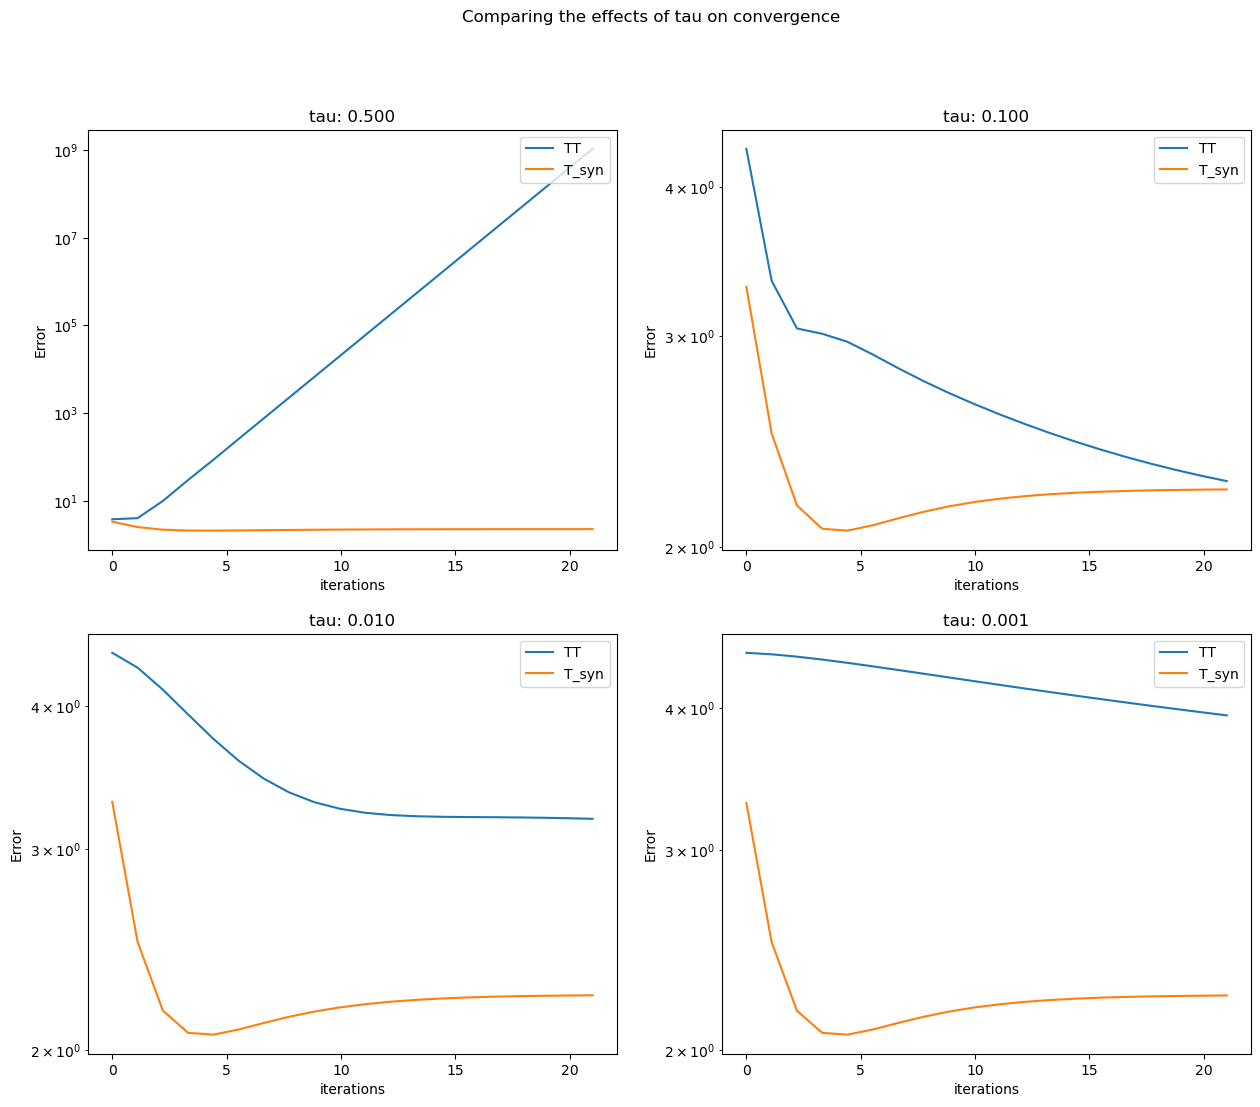

In [8]:
# Convergence plot for varying tau (for both examples)
iter = 20
tau_values = [0.5, 0.1, 0.01, 0.001]
z = np.linspace(0, iter+1, iter)
ncol = 2
nrow = len(tau_values) // ncol + (len(tau_values) % ncol > 0)


fig, axs = plt.subplots(nrows=nrow, ncols=ncol, figsize=(15, 12))
fig.suptitle('Comparing the effects of tau on convergence', fontsize=12)

for val, ax in zip(tau_values, axs.ravel()):
    err_fixed_TT = []
    err_fixed_T_syn = []
    
    iml12_TT = pyproximal.optimization.primaldual.PrimalDual(S_TT, R_TT, TT_Top,
                                                  tau=val, mu=0.95, theta=1.,
                                                  x0=np.ones(TT_rho.shape[0]),
                                                  gfirst=False, niter=iter, show=True,
                                                  callback=lambda x:err_fixed_TT.append(np.linalg.norm(x-TT_rho)))

    iml12_T_syn = pyproximal.optimization.primaldual.PrimalDual(S_T_syn, R_T_syn, T_syn_Top,
                                                  tau=0.95, mu=0.95, theta=1.,
                                                  x0=np.ones(T_syn_rho.shape[0]),
                                                  gfirst=False, niter=iter, show=True,
                                                  callback=lambda x:err_fixed_T_syn.append(np.linalg.norm(x-T_syn_rho)))


    ax.semilogy(z, err_fixed_TT, label="TT")
    ax.semilogy(z, err_fixed_T_syn, label="T_syn")
    ax.set_xlabel('iterations')
    ax.set_ylabel('Error')
    ax.set_title(r'tau: %.3f' %val)
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(labels, loc='upper right')
plt.show()

In [17]:
## Data Matrix
l = TT.shape[0] * TT.shape[1]
TT = TT.reshape(l, 1)

Top = pylops.MatrixMult(dims=(TT.shape[1], TT.shape[0]), A=TT)
rho = np.eye(int(np.sqrt(TT.shape[1]))).reshape(-1) # zeros
g = TT@rho

eucl = pyproximal.L21(ndim= len(g) , sigma=2.)
tau = .02
eucl.prox(g, tau)
eucl.proxdual(g, tau)


# #Other term 
R_TT = pyproximal.L1(sigma=2.)

###################################################################################

## Synthetic data
l_ = T_syn.shape[0] * T_syn.shape[1]
T_syn = T_syn.reshape(l_, 1)

Top_ = pylops.MatrixMult(dims=(T_syn.shape[1], T_syn.shape[0]), A=T_syn)
rho_ = np.eye(int(np.sqrt(T_syn.shape[1]))).reshape(-1)
g_ = T_syn@rho_

#data fidelity term
eucl_ = pyproximal.L21(ndim= len(g_) , sigma=2.)
tau = 2

eucl_.prox(g_, tau)
eucl_.proxdual(g_, tau)

# #Other term 
R_TT_ = pyproximal.L1(sigma=2.)

err_fixed_TT = []
err_fixed_T_syn = []

iml12_TT = pyproximal.optimization.primaldual.PrimalDual(eucl, R_TT, Top,
                                                  tau=0.95, mu=0.95, theta=1.,
                                                  x0=np.ones(TT.shape[0]),
                                                  gfirst=False, niter=300, show=True,
                                                  callback=lambda x:err_fixed_TT.append(np.linalg.norm(x-g)))

iml12_T_syn = pyproximal.optimization.primaldual.PrimalDual(eucl_, R_TT_, Top_,
                                                  tau=0.95, mu=0.95, theta=1.,
                                                  x0=np.ones(T_syn.shape[0]),
                                                  gfirst=False, niter=300, show=True,
                                                  callback=lambda x:err_fixed_T_syn.append(np.linalg.norm(x-g_)))

Primal-dual: min_x f(Ax) + x^T z + g(x)
---------------------------------------------------------
Proximal operator (f): <class 'pyproximal.proximal.L21.L21'>
Proximal operator (g): <class 'pyproximal.proximal.L1.L1'>
Linear operator (A): <class 'pylops.basicoperators.MatrixMult.MatrixMult'>
Additional vector (z): None
tau = 0.95		mu = 0.95
theta = 1.00		niter = 300

   Itn       x[0]          f           g          z^x       J = f + g + z^x
     1   9.62000e-01   9.620e+01   4.810e+05   0.000e+00       4.811e+05
     2  -6.65969e+00   6.660e+02   3.330e+06   0.000e+00       3.331e+06
     3   9.83357e+01   9.834e+03   4.917e+07   0.000e+00       4.918e+07
     4  -8.95220e+01   8.952e+03   4.476e+07   0.000e+00       4.477e+07
     5   9.63184e+01   9.632e+03   4.816e+07   0.000e+00       4.817e+07
     6  -9.15988e+01   9.160e+03   4.580e+07   0.000e+00       4.581e+07
     7   9.42409e+01   9.424e+03   4.712e+07   0.000e+00       4.713e+07
     8  -9.36830e+01   9.368e+03   4.684e+0

Primal-dual: min_x f(Ax) + x^T z + g(x)
---------------------------------------------------------
Proximal operator (f): <class 'pyproximal.proximal.L21.L21'>
Proximal operator (g): <class 'pyproximal.proximal.L1.L1'>
Linear operator (A): <class 'pylops.basicoperators.MatrixMult.MatrixMult'>
Additional vector (z): None
tau = 0.5		mu = 0.95
theta = 1.00		niter = 15

   Itn       x[0]          f           g          z^x       J = f + g + z^x
     1   9.80000e-01   9.800e+01   4.900e+05   0.000e+00       4.901e+05
     2  -3.18849e+00   3.188e+02   1.594e+06   0.000e+00       1.595e+06
     3   2.47015e+01   2.470e+03   1.235e+07   0.000e+00       1.235e+07
     4  -6.86742e+01   6.867e+03   3.434e+07   0.000e+00       3.434e+07
     5   2.92829e+01   2.928e+03   1.464e+07   0.000e+00       1.464e+07
     6  -6.44512e+01   6.445e+03   3.223e+07   0.000e+00       3.223e+07
     7   3.40032e+01   3.400e+03   1.700e+07   0.000e+00       1.701e+07
     8  -5.96963e+01   5.970e+03   2.985e+07 

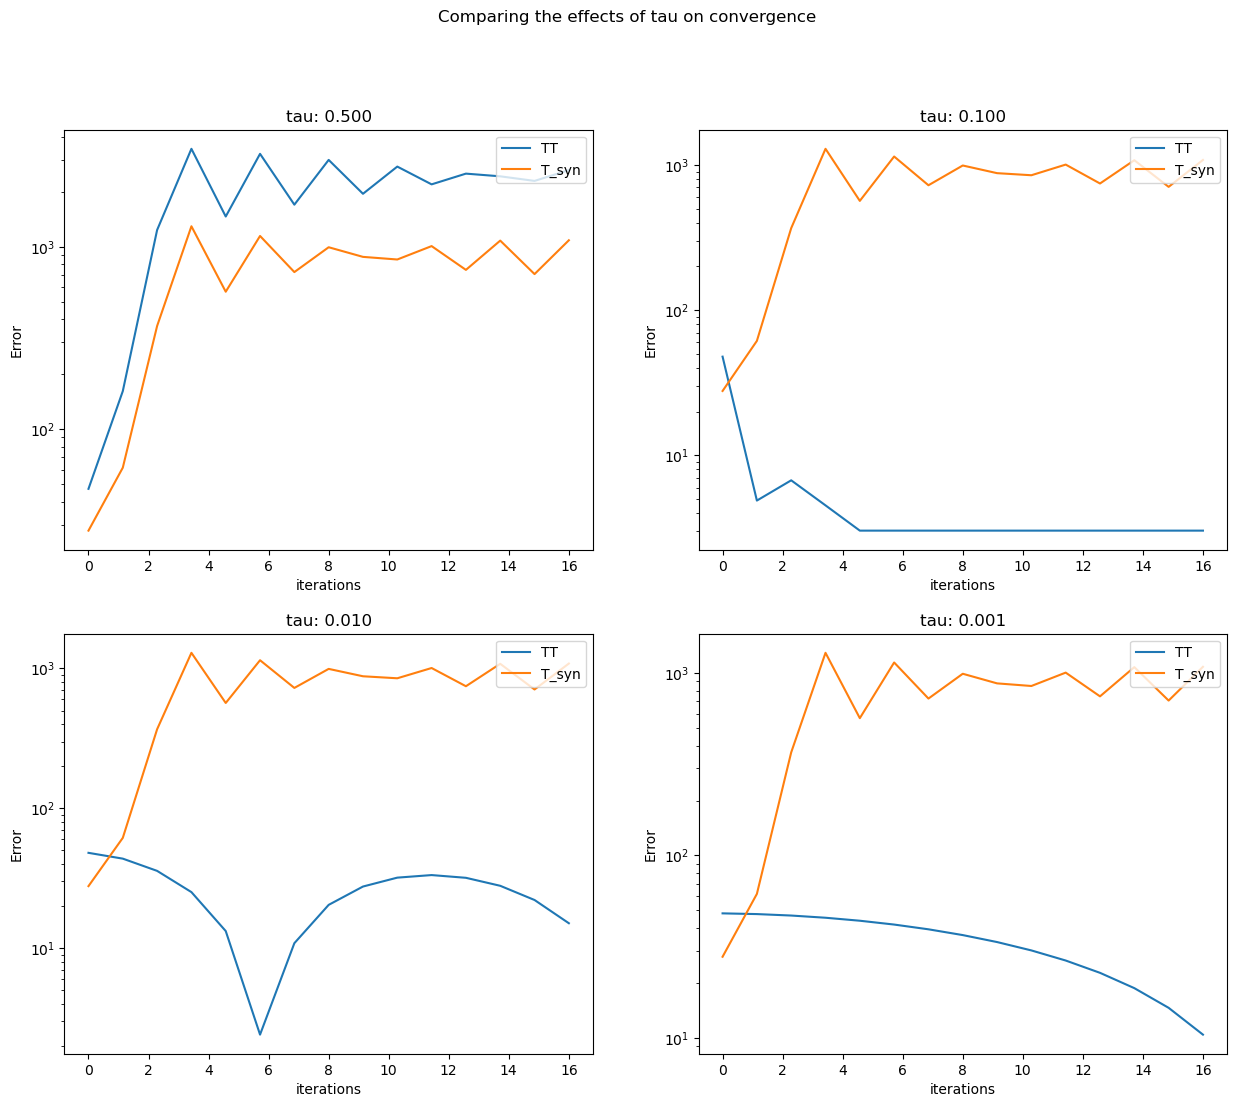

In [19]:
# Convergence plot for varying tau (for both examples)
iter = 15
tau_values = [0.5, 0.1, 0.01, 0.001]
z = np.linspace(0, iter+1, iter)
ncol = 2
nrow = len(tau_values) // ncol + (len(tau_values) % ncol > 0)


fig, axs = plt.subplots(nrows=nrow, ncols=ncol, figsize=(15, 12))
fig.suptitle('Comparing the effects of tau on convergence', fontsize=12)

for val, ax in zip(tau_values, axs.ravel()):
    err_fixed_TT = []
    err_fixed_T_syn = []
    
    iml12_TT = pyproximal.optimization.primaldual.PrimalDual(eucl, R_TT, Top,
                                                  tau=val, mu=0.95, theta=1.,
                                                  x0=np.ones(TT.shape[0]),
                                                  gfirst=False, niter=iter, show=True,
                                                  callback=lambda x:err_fixed_TT.append(np.linalg.norm(x-g)))

    iml12_T_syn = pyproximal.optimization.primaldual.PrimalDual(eucl_, R_TT_, Top_,
                                                  tau=0.95, mu=0.95, theta=1.,
                                                  x0=np.ones(T_syn.shape[0]),
                                                  gfirst=False, niter=iter, show=True,
                                                  callback=lambda x:err_fixed_T_syn.append(np.linalg.norm(x-g_)))


    ax.semilogy(z, err_fixed_TT, label="TT")
    ax.semilogy(z, err_fixed_T_syn, label="T_syn")
    ax.set_xlabel('iterations')
    ax.set_ylabel('Error')
    ax.set_title(r'tau: %.3f' %val)
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(labels, loc='upper right')
plt.show()

In [20]:
## Data Matrix

l = TT.shape[0] * TT.shape[1]
TT = TT.reshape(l, 1)

Top = pylops.MatrixMult(dims=(TT.shape[1], TT.shape[0]), A=TT)
rho = np.eye(int(np.sqrt(TT.shape[1]))).reshape(-1) # zeros
g = TT@rho

# L1 data term
S_TT_l1 = pyproximal.L1(sigma=.4)
tau = 2
S_TT_l1.prox(g, tau)
S_TT_l1.proxdual(g, tau)


# other term
R_TT_l1 = pyproximal.L1(sigma=2.)




#################################################################################
## Synthetic data
l_ = T_syn.shape[0] * T_syn.shape[1]
T_syn = T_syn.reshape(l_, 1)

Top_ = pylops.MatrixMult(dims=(T_syn.shape[1], T_syn.shape[0]), A=T_syn)
rho_ = np.eye(int(np.sqrt(T_syn.shape[1]))).reshape(-1)
g_ = T_syn@rho_


# L1 data term
S_Tmat_l1 = pyproximal.L1(sigma=.4)
tau = 2
S_Tmat_l1.prox(g_, tau)
S_Tmat_l1.proxdual(g_, tau)
# other term
R_Tmat_l1 = pyproximal.L1(sigma=2.)


# # Primal-dual
err_fixed_TT = []
err_fixed_T_syn = []
iml12_TT = pyproximal.optimization.primaldual.PrimalDual(S_TT_l1, R_TT_l1, Top,
                                                  tau=0.95, mu=0.95, theta=1.,
                                                  x0=np.ones(TT.shape[0]),
                                                  gfirst=False, niter=300, show=True,
                                                  callback=lambda x:err_fixed_TT.append(np.linalg.norm(x-g)))


iml12_T_syn = pyproximal.optimization.primaldual.PrimalDual(S_Tmat_l1, R_Tmat_l1, Top_,
                                                  tau=0.95, mu=0.95, theta=1.,
                                                  x0=np.ones(T_syn.shape[0]),
                                                  gfirst=False, niter=300, show=True,
                                                  callback=lambda x:err_fixed_T_syn.append(np.linalg.norm(x-g_)))



Primal-dual: min_x f(Ax) + x^T z + g(x)
---------------------------------------------------------
Proximal operator (f): <class 'pyproximal.proximal.L1.L1'>
Proximal operator (g): <class 'pyproximal.proximal.L1.L1'>
Linear operator (A): <class 'pylops.basicoperators.MatrixMult.MatrixMult'>
Additional vector (z): None
tau = 0.95		mu = 0.95
theta = 1.00		niter = 300

   Itn       x[0]          f           g          z^x       J = f + g + z^x
     1   6.20000e-01   6.200e+02   3.100e+05   0.000e+00       3.106e+05
     2  -9.89531e-01   9.895e+02   4.948e+05   0.000e+00       4.958e+05
     3   1.81864e+01   1.819e+04   9.093e+06   0.000e+00       9.111e+06
     4  -1.50448e+02   1.504e+05   7.522e+07   0.000e+00       7.537e+07
     5   3.78369e+01   3.784e+04   1.892e+07   0.000e+00       1.896e+07
     6  -1.45211e+02   1.452e+05   7.261e+07   0.000e+00       7.275e+07
     7   4.34842e+01   4.348e+04   2.174e+07   0.000e+00       2.179e+07
     8  -1.39392e+02   1.394e+05   6.970e+07 

In [ ]:
# Convergence plot for varying tau (for both examples)
iter = 15
tau_values = [0.5, 0.1, 0.01, 0.001]
z = np.linspace(0, iter+1, iter)
ncol = 2
nrow = len(tau_values) // ncol + (len(tau_values) % ncol > 0)


fig, axs = plt.subplots(nrows=nrow, ncols=ncol, figsize=(15, 12))
fig.suptitle('Comparing the effects of tau on convergence', fontsize=12)

for val, ax in zip(tau_values, axs.ravel()):
    err_fixed_TT = []
    err_fixed_T_syn = []
    
    err_fixed_TT = []
    err_fixed_T_syn = []
    iml12_TT = pyproximal.optimization.primaldual.PrimalDual(S_TT_l1, R_TT_l1, Top,
                                                    tau=val, mu=0.95, theta=1.,
                                                    x0=np.ones(TT.shape[0]),
                                                    gfirst=False, niter=iter, show=True,
                                                    callback=lambda x:err_fixed_TT.append(np.linalg.norm(x-g)))


    iml12_T_syn = pyproximal.optimization.primaldual.PrimalDual(S_Tmat_l1, R_Tmat_l1, Top_,
                                                    tau=val, mu=0.95, theta=1.,
                                                    x0=np.ones(T_syn.shape[0]),
                                                    gfirst=False, niter=iter, show=True,
                                                    callback=lambda x:err_fixed_T_syn.append(np.linalg.norm(x-g_)))


    ax.semilogy(z, err_fixed_TT, label="TT")
    ax.semilogy(z, err_fixed_T_syn, label="T_syn")
    ax.set_xlabel('iterations')
    ax.set_ylabel('Error')
    ax.set_title(r'tau: %.3f' %val)
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(labels, loc='upper right')
plt.show()